### Import libraries and datasets:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [ ]:
csv_fts = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\FTS Historical Data.csv"
csv_mwg = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\MWG Historical Data.csv"
csv_vic = "D:\\HK2 (NĂM 3)\\RIGHTNOW\\VIC Historical Data.csv"

df_fts = pd.read_csv(csv_fts, thousands=',')
df_mwg = pd.read_csv(csv_mwg, thousands=',')
df_vic = pd.read_csv(csv_vic, thousands=',')

### Dataset 1: FTS

- Cast Date column to datetime type
- Sort data ascending by Date

In [ ]:
df_fts['Date'] = pd.to_datetime(df_fts['Date'])
df_fts = df_fts.sort_values(by='Date', ascending=True)
df_fts.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,5788.4,5859.2,5859.2,5788.4,103.55K,-1.21%
1358,2018-01-03,5953.7,5764.7,5977.4,5741.1,245.02K,2.86%
1357,2018-01-04,6024.6,5953.7,6142.8,5906.5,167.80K,1.19%
1356,2018-01-05,5882.9,5977.4,6048.2,5882.9,113.88K,-2.35%
1355,2018-01-08,6001.0,5859.2,6001.0,5764.7,63.36K,2.01%


- Split Price data
- Reset index

In [ ]:
df_price = df_fts[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,5788.4
1,5953.7
2,6024.6
3,5882.9
4,6001.0


- Scale data between 0 and 1:

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.000000
1,0.003587
2,0.005125
3,0.002051
4,0.004613


- Split data into train, test, val (7 - 2 - 1):

In [ ]:
train_size = int(0.7 * len(df_price))
test_size = int(0.2 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(951, 1)
(272, 1)
(137, 1)


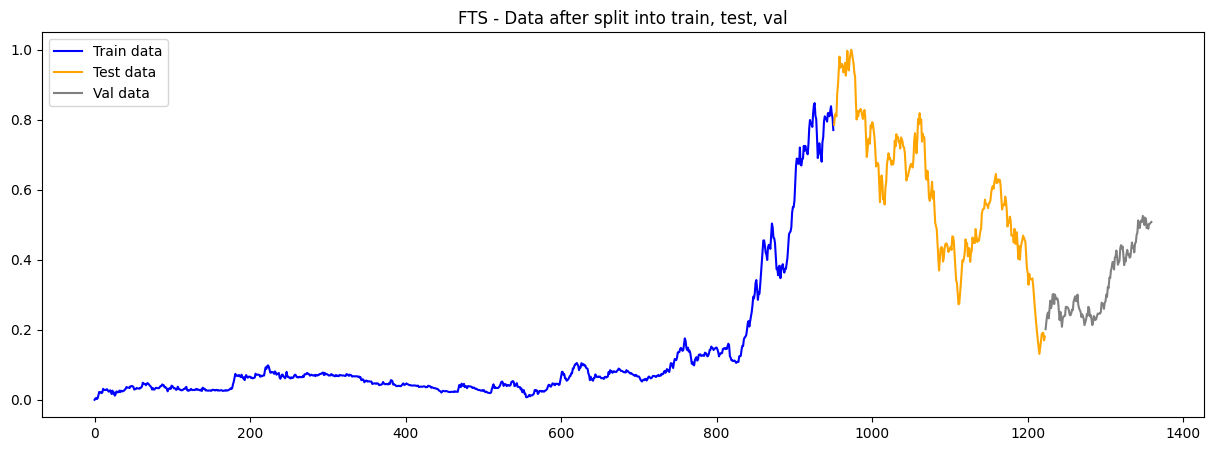

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('FTS - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [ ]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)]
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [ ]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(x_train.shape[1], 1)))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model_rnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


15/15 [==============================] - 1s 23ms/step - loss: 0.0112 - val_loss: 0.0203
Epoch 2/100
15/15 [==============================] - 0s 10ms/step - loss: 6.6364e-04 - val_loss: 0.0049
Epoch 3/100
15/15 [==============================] - 0s 7ms/step - loss: 5.1168e-04 - val_loss: 0.0050
Epoch 4/100
15/15 [==============================] - 0s 7ms/step - loss: 4.0846e-04 - val_loss: 0.0035
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 3.8902e-04 - val_loss: 0.0038
Epoch 6/100
15/15 [==============================] - 0s 6ms/step - loss: 3.7241e-04 - val_loss: 0.0031
Epoch 7/100
15/15 [==============================] - 0s 7ms/step - loss: 3.8478e-04 - val_loss: 0.0037
Epoch 8/100
15/15 [==============================] - 0s 8ms/step - loss: 3.1171e-04 - val_loss: 0.0039
Epoch 9/100
15/15 [==============================] - 0s 7ms/step - loss: 3.0583e-04 - val_loss: 0.0045
Epoch 10/100
15/15 [==============================] - 0s 7ms/step - loss: 2.8559e-04 - 

- Model Prediction on test, val (one-step prediction):

In [ ]:
y_pred_test = model_rnn.predict(x_test)
y_pred_val = model_rnn.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 2ms/step


- 30 days prediction:

In [ ]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_rnn.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1

In [ ]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[25787.666],
       [26106.676],
       [27316.453],
       [27392.127],
       [28139.191],
       [28222.719],
       [28782.523],
       [29202.209],
       [29702.064],
       [30946.07 ],
       [31572.049],
       [32446.166],
       [33066.93 ],
       [33787.484],
       [34758.418],
       [35315.42 ],
       [35997.723],
       [36353.848],
       [36817.6  ],
       [37635.605],
       [38110.96 ],
       [38742.953],
       [39479.65 ],
       [39778.145],
       [40304.707],
       [40429.746],
       [40726.176],
       [41001.895],
       [41170.645],
       [41362.812]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [ ]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 33068.3532
Validating RMSE: 22938.6582
Predicting 30 days RMSE: 34727.4709

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 98.3929
Validating MSLE: 94.077
Predicting 30 days MSLE: 100.8604


- Prediction plotting:

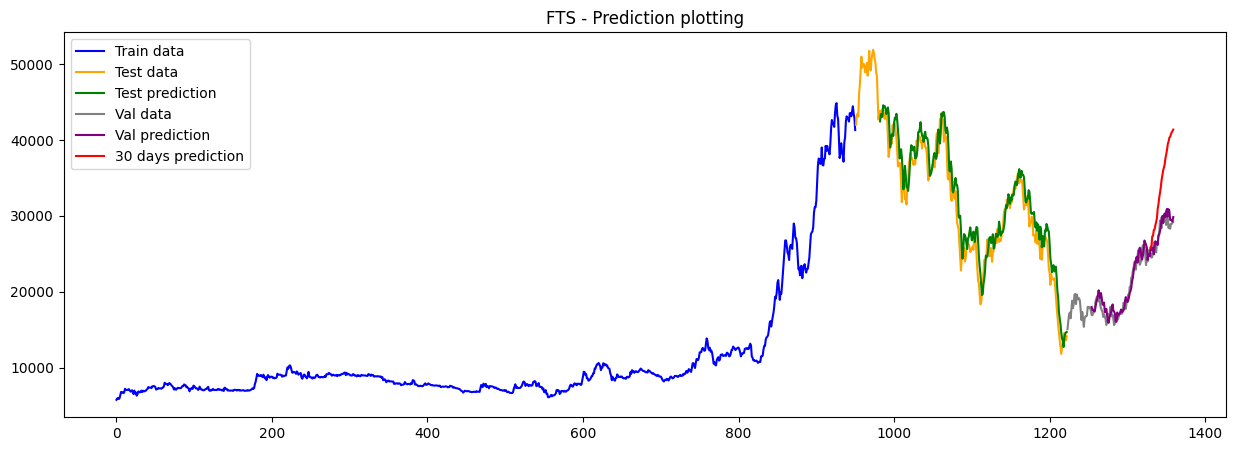

In [ ]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('FTS - Prediction plotting')
plt.show()

### Dataset 2: MWG

In [ ]:
df_mwg['Date'] = pd.to_datetime(df_mwg['Date'])
df_mwg = df_mwg.sort_values(by='Date', ascending=True)
df_mwg.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,31276,31039,31394,31039,2.27M,0.76%
1358,2018-01-03,31892,31323,32034,31276,4.53M,1.97%
1357,2018-01-04,31963,31773,32081,31750,2.71M,0.22%
1356,2018-01-05,31608,31987,31987,31465,2.93M,-1.11%
1355,2018-01-08,31110,31394,31513,31039,3.01M,-1.58%


- Split Price data
- Reset index

In [ ]:
df_price = df_mwg[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,31276
1,31892
2,31963
3,31608
4,31110


- Scale data between 0 and 1:

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.200020
1,0.210221
2,0.211397
3,0.205518
4,0.197271


- Split data into train, test, val (7 - 2 - 1):

In [ ]:
train_size = int(0.7 * len(df_price))
test_size = int(0.2 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(951, 1)
(272, 1)
(137, 1)


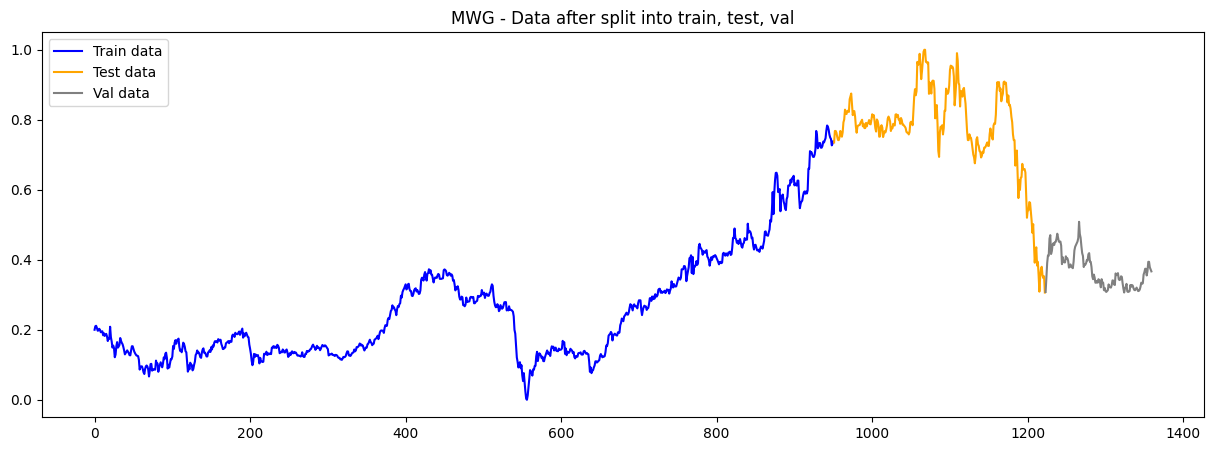

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('MWG - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [ ]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)]
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [ ]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(x_train.shape[1], 1)))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model_rnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


15/15 [==============================] - 1s 23ms/step - loss: 0.0276 - val_loss: 0.0212
Epoch 2/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0085
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0054
Epoch 4/100
15/15 [==============================] - 0s 7ms/step - loss: 7.9774e-04 - val_loss: 0.0074
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 7.1786e-04 - val_loss: 0.0052
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 6.6158e-04 - val_loss: 0.0053
Epoch 7/100
15/15 [==============================] - 0s 7ms/step - loss: 6.3258e-04 - val_loss: 0.0041
Epoch 8/100
15/15 [==============================] - 0s 8ms/step - loss: 5.9307e-04 - val_loss: 0.0043
Epoch 9/100
15/15 [==============================] - 0s 7ms/step - loss: 5.8408e-04 - val_loss: 0.0034
Epoch 10/100
15/15 [==============================] - 0s 7ms/step - loss: 5.5347e-04 - val_loss:

- Model Prediction on test, val (one-step prediction):

In [ ]:
y_pred_test = model_rnn.predict(x_test)
y_pred_val = model_rnn.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 2ms/step


- 30 days prediction:

In [ ]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_rnn.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [ ]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[37554.938],
       [37541.164],
       [37432.438],
       [37763.754],
       [37650.645],
       [37591.855],
       [37578.36 ],
       [37510.684],
       [37488.22 ],
       [37484.473],
       [37733.16 ],
       [37528.91 ],
       [37557.934],
       [37389.26 ],
       [37511.375],
       [37388.78 ],
       [37343.28 ],
       [37286.84 ],
       [37288.15 ],
       [37254.977],
       [37129.777],
       [36998.008],
       [36839.984],
       [36900.58 ],
       [36890.656],
       [36824.32 ],
       [36713.09 ],
       [36658.168],
       [36571.688],
       [36512.67 ]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [ ]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 66420.7794
Validating RMSE: 40916.0004
Predicting 30 days RMSE: 37265.3338

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 110.6896
Validating MSLE: 106.3016
Predicting 30 days MSLE: 104.731


- Prediction plotting:

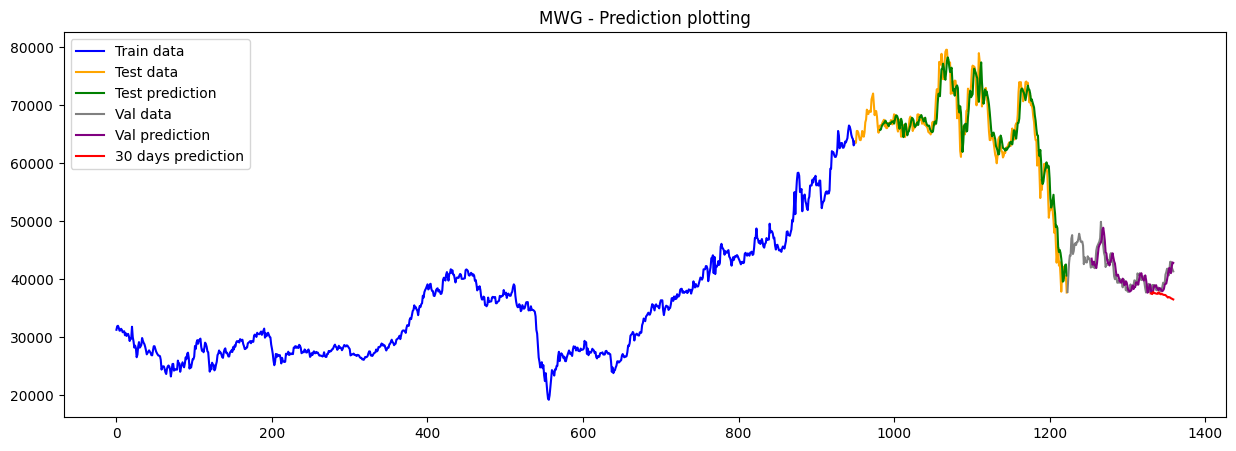

In [ ]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('MWG - Prediction plotting')
plt.show()

- Prediction plotting:

### Dataset 3: VIC

In [ ]:
df_vic['Date'] = pd.to_datetime(df_vic['Date'])
df_vic = df_vic.sort_values(by='Date', ascending=True)
df_vic.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
1359,2018-01-02,64628,64132,64876,63967,1.74M,1.16%
1358,2018-01-03,66529,65702,68760,64959,6.07M,2.94%
1357,2018-01-04,66942,67355,68678,66529,3.55M,0.62%
1356,2018-01-05,66116,66942,66942,65289,3.42M,-1.23%
1355,2018-01-08,66364,66116,67686,65372,4.81M,0.38%


- Split Price data
- Reset index

In [ ]:
df_price = df_vic[['Price']]
df_price = df_price.reset_index(drop=True)
df_price.head(5)

,Price
0,64628
1,66529
2,66942
3,66116
4,66364


- Scale data between 0 and 1:

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_price['Price'] = scaler.fit_transform(np.array(df_price['Price']).reshape(-1,1))
df_price.head(5)

,Price
0,0.182297
1,0.206826
2,0.212155
3,0.201497
4,0.204697


- Split data into train, test, val (7 - 2 - 1):

In [ ]:
train_size = int(0.7 * len(df_price))
test_size = int(0.2 * len(df_price))
val_size = len(df_price) - train_size - test_size

train_data = df_price[:train_size]
test_data = df_price[train_size:train_size+test_size]
val_data = df_price[train_size+test_size:]

print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(951, 1)
(272, 1)
(137, 1)


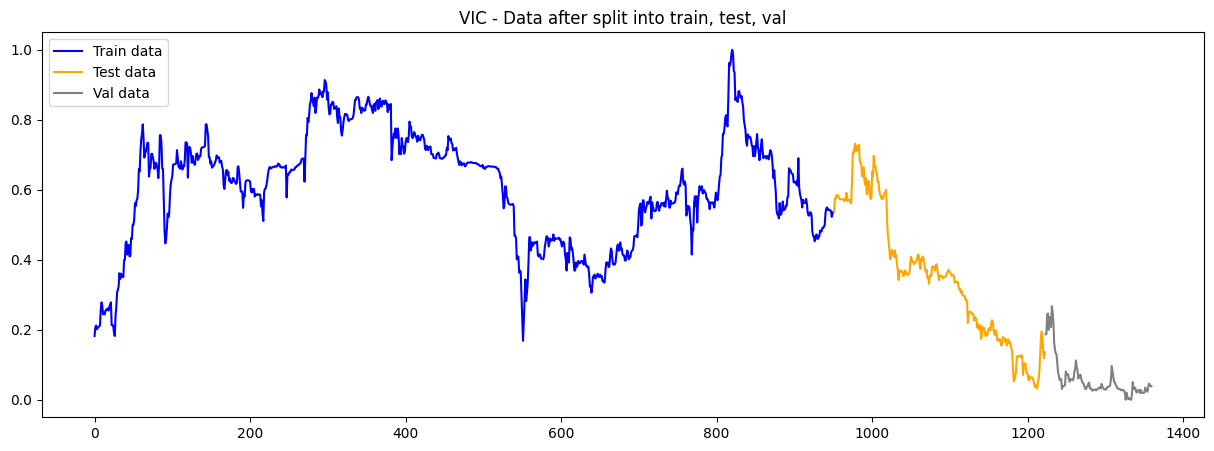

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Price'], 'b')
plt.plot(test_data.index, test_data['Price'], 'orange')
plt.plot(val_data.index, val_data['Price'], 'gray')
plt.legend(['Train data', 'Test data', 'Val data'], loc='upper left')
plt.title('VIC - Data after split into train, test, val')
plt.show()

- Prepare x, y data:

In [ ]:
def make_lags_data(dataset, lags=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - lags - 1):
		a = dataset[i:(i + lags)]
		dataX.append(a)
		dataY.append(dataset[i + lags])
	return np.array(dataX), np.array(dataY)

In [ ]:
lags = 30

x_train, y_train = make_lags_data(train_data['Price'].values, lags=lags)

x_test, y_test = make_lags_data(test_data['Price'].values, lags=lags)

x_val, y_val = make_lags_data(val_data['Price'].values, lags=lags)

- Reshape data:

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

- Model training:

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(50, input_shape=(x_train.shape[1], 1)))
model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model_rnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100


15/15 [==============================] - 1s 21ms/step - loss: 0.0953 - val_loss: 0.0192
Epoch 2/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 0.0107
Epoch 3/100
15/15 [==============================] - 0s 9ms/step - loss: 0.0036 - val_loss: 0.0064
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0022 - val_loss: 0.0038
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0029
Epoch 7/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 8/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 9/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/100
15/15 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 11/100
15/15 [

- Model Prediction on test, val (one-step prediction):

In [ ]:
y_pred_test = model_rnn.predict(x_test)
y_pred_val = model_rnn.predict(x_val)

y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)

4/4 [==============================] - 0s 3ms/step


- 30 days prediction:

In [ ]:
number_of_days_to_predict = 30
n_steps = lags

x_input = df_price[-number_of_days_to_predict-lags:-number_of_days_to_predict]['Price'].values
temp_input = x_input.tolist()

ndays_pred = []

i = 0
while(i < number_of_days_to_predict):
    x_input = np.array(temp_input)
    x_input = x_input.reshape(1, lags, 1)
    y_hat = model_rnn.predict(x_input, verbose=0)
    temp_input.extend(y_hat[0])
    temp_input = temp_input[1:]
    ndays_pred.extend(y_hat[0])
    i += 1


In [ ]:
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))
ndays_pred

array([[ 54939.12 ],
       [ 57423.613],
       [ 59964.312],
       [ 61358.434],
       [ 61784.555],
       [ 62539.5  ],
       [ 65135.074],
       [ 69487.125],
       [ 73658.81 ],
       [ 78103.36 ],
       [ 81251.1  ],
       [ 84908.89 ],
       [ 89414.12 ],
       [ 92921.32 ],
       [ 96719.78 ],
       [ 99790.1  ],
       [101830.19 ],
       [103800.8  ],
       [105249.625],
       [106314.664],
       [107379.31 ],
       [108272.65 ],
       [108813.01 ],
       [109436.04 ],
       [109491.51 ],
       [109140.84 ],
       [108760.984],
       [107889.734],
       [107145.65 ],
       [106719.695]], dtype=float32)

- Model evaluating (RMSE - MAPE - MSLE):

In [ ]:
last_ndays_data = df_price[-number_of_days_to_predict:]['Price'].values

# RMSE
test_rmse = mean_squared_error(y_pred_test, y_test, squared=False)
val_rmse = mean_squared_error(y_pred_val, y_val, squared=False)
ndays_rmse = mean_squared_error(ndays_pred, last_ndays_data, squared=False)
print('Testing RMSE:', np.round(test_rmse, 4))
print('Validating RMSE:', np.round(val_rmse, 4))
print('Predicting {0} days RMSE:'.format(number_of_days_to_predict), np.round(ndays_rmse, 4))

# MAPE
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
ndays_mape = mean_absolute_percentage_error(ndays_pred, last_ndays_data)
print('\nTesting MAPE:', np.round(test_mape, 4))
print('Validating MAPE:', np.round(val_mape, 4))
print('Predicting {0} days MAPE:'.format(number_of_days_to_predict), np.round(ndays_mape, 4))

# MSLE
test_msle = mean_squared_log_error(y_pred_test, y_test)
val_msle = mean_squared_log_error(y_pred_val, y_val)
ndays_msle = mean_squared_log_error(ndays_pred, last_ndays_data)
print('\nTesting MSLE:', np.round(test_msle, 4))
print('Validating MSLE:', np.round(val_msle, 4))
print('Predicting {0} days MSLE:'.format(number_of_days_to_predict), np.round(ndays_msle, 4))


Testing RMSE: 76906.6599
Validating RMSE: 57048.6267
Predicting 30 days RMSE: 91758.2785

Testing MAPE: 1.0
Validating MAPE: 1.0
Predicting 30 days MAPE: 1.0

Testing MSLE: 119.9691
Validating MSLE: 119.1043
Predicting 30 days MSLE: 128.9176


- Prediction plotting:

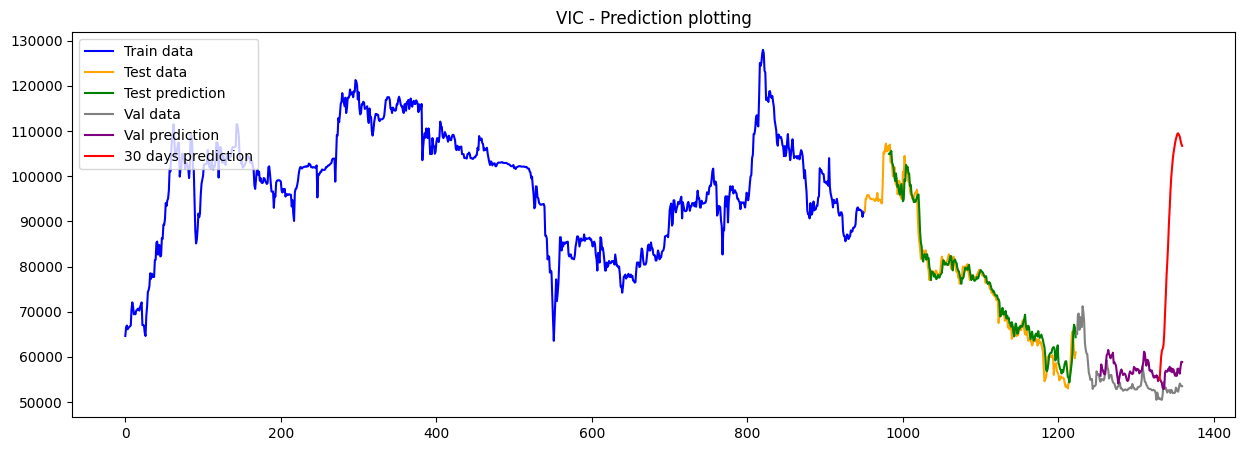

In [ ]:
plt.figure(figsize=(15,5))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data), c='b')

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), 'orange')

test_data_index = pd.RangeIndex(start=train_size + lags + 1, stop=train_size+test_size, step=1)
plt.plot(test_data_index, (y_pred_test), 'green')

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, scaler.inverse_transform(val_data), 'gray')

val_data_index = pd.RangeIndex(start=train_size+test_size + lags + 1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, y_pred_val, 'purple')

prediect_data_index = pd.RangeIndex(start=len(df_price)-number_of_days_to_predict, stop=len(df_price), step=1)
plt.plot(prediect_data_index, ndays_pred, 'red')

plt.legend(['Train data', 'Test data', 'Test prediction', 'Val data', 'Val prediction', '{0} days prediction'.format(number_of_days_to_predict)], loc='upper left')
plt.title('VIC - Prediction plotting')
plt.show()